# 经费数字画像

* Content：通过经费数据找出异常点，对M方用了什么武器等进行画像，最终的目的是基于经费数字画像，感知M方的战略意图
* Author:  HuiHui
* Date:    2020-03-10
* Reference:

In [1]:
# !/usr/bin/env python
# -*- coding=utf-8 -*-
import pandas as pd
import numpy as np
import pymysql
import re

In [2]:
# 从mysql数据库获取数据
sql = 'select * from authorized_procurement'
def export():
    conn = pymysql.connect(host='localhost', user='root', passwd='1234', db='usabudget',charset="utf8")
    # 得到一个可以执行SQL语句的光标对象
    cursor = conn.cursor()  # 执行完毕返回的结果集默认以元组显示
    cursor.execute(sql)
    data=cursor.fetchall()
    #print(data)
    columnDes = cursor.description  # 获取连接对象的描述信息
    columnNames = [columnDes[i][0] for i in range(len(columnDes))] #列索引
    df = pd.DataFrame([list(i) for i in data], columns=columnNames) #转换成DATAFRAME格式
    #print(df)

    # 关闭光标对象
    cursor.close()
    # 关闭数据库连接
    conn.close()
    return df

try:
    df=export()
    print("OK")

except Exception as e:
    print("ERROR")

OK


In [3]:
# 数据探索
print('查看数据信息：列名、非空个数、类型等')
df.info()
print('～'*30)
print('查看数据摘要') #数值型特征统计信息
print(df.describe())
print('～'*30)
print('查看离散数据分布')
print(df.describe(include=['O'])) #include=['O']，会计算离散型变量的统计特征，
print('～'*30)
print('查看前5条数据')
df.head(5)

查看数据信息：列名、非空个数、类型等
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 15 columns):
ID           10128 non-null int64
PubYear      10128 non-null object
ForceType    10128 non-null object
Line         10128 non-null object
Item         10128 non-null object
QtyR         10128 non-null object
CostR        10128 non-null object
QtyHA        10128 non-null object
CostHA       10128 non-null object
QtySA        10128 non-null object
CostSA       10128 non-null object
QtyCC        10128 non-null object
CostCC       10128 non-null object
QtyCA        10128 non-null object
CostCA       10128 non-null object
dtypes: int64(1), object(14)
memory usage: 1.2+ MB
～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～
查看数据摘要
                 ID
count  10128.000000
mean   18387.523400
std     4288.894586
min    10578.000000
25%    14713.750000
50%    18556.500000
75%    22069.250000
max    25941.000000
～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～
查看离散数据分布
       PubYear   ForceType   Line      

,ID,PubYear,ForceType,Line,Item,QtyR,CostR,QtyHA,CostHA,QtySA,CostSA,QtyCC,CostCC,QtyCA,CostCA
0,10578,2019,af aircraft,,TACTICAL FORCES,,,,,,,,,,
1,10579,2019,af aircraft,1,F–35,48,4261021,48,4177681,47,4193521,,"–83,340",48,4177681
2,10580,2019,af aircraft,,Production Efficiences,,,,"[–83,340]",,,,"[–83,340]",,
3,10581,2019,af aircraft,,Program Realignment,,,,,[–1],"[–67,500]",,,,
4,10582,2019,af aircraft,2,ADVANCE PROCUREMENT (CY),,406000,,406000,,406000,,,,406000


In [4]:
# 数据处理

#PubYear转换为时间类型,取年份
df["PubYear"]=pd.to_datetime(df["PubYear"]).dt.year
#print(df["PubYear"].dtype)

# print(df['QtyCA'][1])
# print(type(df['QtyCA'][1]))
# print(df['QtyCA'][0])
# print(type(df['QtyCA'][0]))
# print(df['QtyCA'][0]==str(""))
#将空格转换为nan值
def blank_to_nan(df,column_names):
    for column in column_names:
        #df[column]=df[column].map({str(""):np.nan})
        df[column]=df[column].apply(lambda x:(np.nan) if x==str("") else x)

blank_to_nan(df,["Line","Item","QtyR","CostR","QtyHA","CostHA","QtySA","CostSA","QtyCC","CostCC","QtyCA","CostCA"])      
print('查看处理后数据信息：列名、非空个数、类型等')
df.info()

#用‘0’补全nan值
df_fillna=df
df_fillna=df_fillna.fillna(str(0))
print('查看处理后数据信息：列名、非空个数、类型等')
df_fillna.info()

查看处理后数据信息：列名、非空个数、类型等
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 15 columns):
ID           10128 non-null int64
PubYear      10128 non-null int64
ForceType    10128 non-null object
Line         6550 non-null object
Item         10128 non-null object
QtyR         972 non-null object
CostR        6484 non-null object
QtyHA        1143 non-null object
CostHA       7008 non-null object
QtySA        1515 non-null object
CostSA       6806 non-null object
QtyCC        483 non-null object
CostCC       2548 non-null object
QtyCA        1013 non-null object
CostCA       6010 non-null object
dtypes: int64(2), object(13)
memory usage: 1.2+ MB
查看处理后数据信息：列名、非空个数、类型等
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 15 columns):
ID           10128 non-null int64
PubYear      10128 non-null int64
ForceType    10128 non-null object
Line         10128 non-null object
Item         10128 non-null object
QtyR

In [5]:
#数据类型转换

#处理([ –1,—000]\n\t\r)这样的str
def element_to_float(s):
    #print(s)
    s=re.sub('[()\\[\\]]','',s)#删除中/圆括号  
    s=re.sub(',','',s)#删除逗号
    s=s.replace(' ', "")#删除空格
    s=s.replace("\n", "")#删除换行符号
    s=s.replace("\r", "")#删除回车符号
    s=s.replace("\t", "")#删除制表符
    if '–' in s or '—' in s:
        s=re.sub(u'[\u2013]','',s) #删除中文横线
        s=re.sub(u'[\u2014]','',s)
        if s!=str(''):
            s=-float(s)#变成负数❓❓❓这里怎么会有负号
    if s==str(''):
        s=float(0)
    else:
        s=float(s)
    #print(s)
    return s

#转换成float类型
def str_to_float(df,column_names):
    for column in column_names:
        df[column]=df[column].apply(lambda x:element_to_float((str(x))))
        
column_names=["QtyR","CostR","QtyHA","CostHA","QtySA","CostSA","QtyCC","CostCC","QtyCA","CostCA"]
str_to_float(df_fillna,column_names)

print('查看处理后数据信息：列名、非空个数、类型等')
df_fillna.info()
df_fillna.head()

查看处理后数据信息：列名、非空个数、类型等
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 15 columns):
ID           10128 non-null int64
PubYear      10128 non-null int64
ForceType    10128 non-null object
Line         10128 non-null object
Item         10128 non-null object
QtyR         10128 non-null float64
CostR        10128 non-null float64
QtyHA        10128 non-null float64
CostHA       10128 non-null float64
QtySA        10128 non-null float64
CostSA       10128 non-null float64
QtyCC        10128 non-null float64
CostCC       10128 non-null float64
QtyCA        10128 non-null float64
CostCA       10128 non-null float64
dtypes: float64(10), int64(2), object(3)
memory usage: 1.2+ MB


,ID,PubYear,ForceType,Line,Item,QtyR,CostR,QtyHA,CostHA,QtySA,CostSA,QtyCC,CostCC,QtyCA,CostCA
0,10578,2019,af aircraft,0,TACTICAL FORCES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10579,2019,af aircraft,1,F–35,48.0,4261021.0,48.0,4177681.0,47.0,4193521.0,0.0,-83340.0,48.0,4177681.0
2,10580,2019,af aircraft,0,Production Efficiences,0.0,0.0,0.0,-83340.0,0.0,0.0,0.0,-83340.0,0.0,0.0
3,10581,2019,af aircraft,0,Program Realignment,0.0,0.0,0.0,0.0,-1.0,-67500.0,0.0,0.0,0.0,0.0
4,10582,2019,af aircraft,2,ADVANCE PROCUREMENT (CY),0.0,406000.0,0.0,406000.0,0.0,406000.0,0.0,0.0,0.0,406000.0


In [6]:
# # 查看unicode编码
# text='–'
# print(text.encode('unicode-escape'))

In [7]:
# #test
# ee="(18008)"
# ss='\n'
# bb='\t'
# aa=str('—7')
# datal = {
#     'state':['Ohio','Ohio','Ohio','Nevada','Nevada'],
#     'year':[ee,ss,bb,aa,2012],
#     'pop':[1.5,1.7,3.6,2.4,2.9]
# }
# datal=pd.DataFrame(datal)
# str_to_float(datal,['year'])
# print(datal['year'])

## 完成数据处理工作
* 至此，数据简单处理工作完成
* 数据还存在的问题有：缺失值用0补全是否合理❓数据中负数出现是否合理❓‘Line’的含义❓

In [8]:
#新增一列总Cost，一列总Qty
df_fillna['CostALL']=df_fillna['CostR']+df_fillna['CostHA']+df_fillna['CostSA']+df_fillna['CostCA']+df_fillna['CostCC']
df_fillna['QtyALL']=df_fillna['QtyR']+df_fillna['QtyHA']+df_fillna['QtySA']+df_fillna['QtyCA']+df_fillna['QtyCC']
print(df_fillna[['QtyR','QtyHA','QtySA','QtyCA','QtyCC']])
print(df_fillna['CostALL'])
print(df_fillna['QtyALL'])

       QtyR  QtyHA  QtySA  QtyCA  QtyCC
0       0.0    0.0    0.0    0.0    0.0
1      48.0   48.0   47.0   48.0    0.0
2       0.0    0.0    0.0    0.0    0.0
3       0.0    0.0   -1.0    0.0    0.0
4       0.0    0.0    0.0    0.0    0.0
5       0.0    0.0    0.0    0.0    0.0
6       0.0    0.0    0.0    0.0    0.0
7       0.0    0.0    0.0    0.0    0.0
8       2.0    0.0    2.0    2.0    0.0
9       0.0   -2.0    0.0    0.0    0.0
10      0.0    0.0    0.0    0.0    0.0
11     15.0   12.0   14.0   15.0    0.0
12      0.0   -3.0    0.0    0.0    0.0
13      0.0    0.0    0.0    0.0    0.0
14      0.0    0.0   -1.0    0.0    0.0
15      0.0    0.0    0.0    0.0    0.0
16      0.0    0.0    0.0    0.0    0.0
17      0.0    0.0    0.0    0.0    0.0
18      1.0    1.0    1.0    1.0    0.0
19      6.0    6.0    6.0    6.0    0.0
20      0.0    0.0    0.0    0.0    0.0
21      0.0    0.0    0.0    0.0    0.0
22      0.0    0.0    0.0    0.0    0.0
23     10.0   10.0   10.0   10.0    0.0


In [9]:
#按年汇总Cost和Qty
df_year_group=df_fillna[['CostR','CostHA','CostSA','CostCA','CostCC','CostALL','QtyR','QtyHA','QtySA','QtyCA','QtyCC','QtyALL']].groupby(df_fillna["PubYear"]).sum()
df_year_group.head(10)

,CostR,CostHA,CostSA,CostCA,CostCC,CostALL,QtyR,QtyHA,QtySA,QtyCA,QtyCC,QtyALL
PubYear,,,,,,,,,,,,
2012,209196778.0,208134576.0,180178352.0,155510891.0,-20373200.0,7.326474e+08,247142.0,247082.0,247142.0,33616876.0,-1934099.0,32424143.0
2013,159951584.0,93432517.0,84482204.0,88694511.0,71207331.0,4.977681e+08,250566.0,56210.0,76027122.0,3650478.0,1132939.0,81117315.0
2014,186207962.0,190416071.0,186040277.0,186827846.0,982074.0,7.504742e+08,456128.0,452062.0,362165.0,393498.0,-146193.0,1517660.0
2015,268524102.0,274461578.0,268589442.0,274198083.0,7575508.0,1.093349e+09,474309.0,474769.0,474885.0,464418.0,412.0,1888793.0
2016,213735384.0,222235065.0,229317936.0,220661892.0,10389762.0,8.963400e+08,45570.0,49017.0,45984.0,47374.0,2706.0,190651.0
2017,203744584.0,206751835.0,205134756.0,204345320.0,901104.0,8.208776e+08,54882.0,55032.0,55200.0,54982.0,150.0,220246.0
2018,232585375.0,295833806.0,307996074.0,274038640.0,62236217.0,1.172690e+09,71392.0,182853.0,81385.0,138621.0,100832.0,575083.0
2019,255796952.0,265109974.0,260215112.0,259501670.0,5565577.0,1.046189e+09,60144.0,126669.0,56658.0,103736.0,65385.0,412592.0


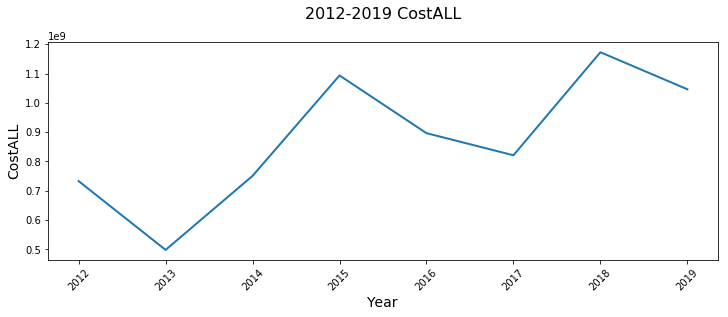

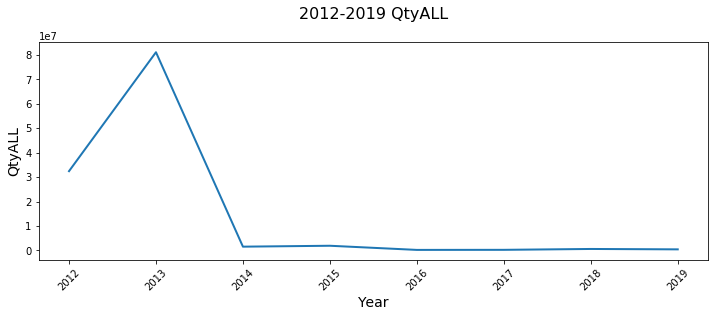

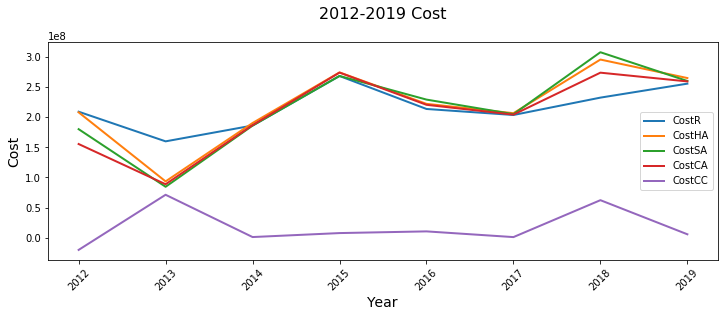

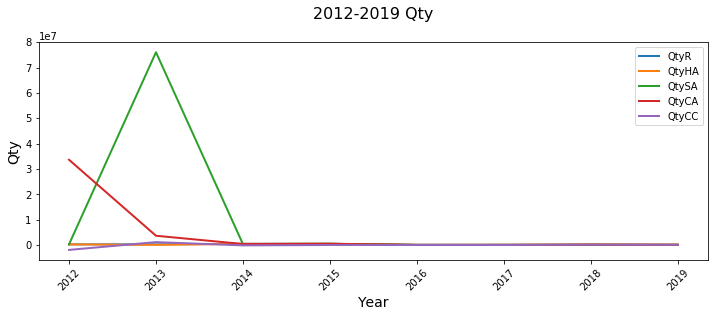

In [10]:
#每年Cost和Qty汇总数据可视化

import matplotlib.pyplot as plt
#"inline"可直接在python console里面生成图像
%matplotlib inline

#定义绘图函数(分开绘制)
def plotting(dataframe):
    for column in dataframe:
        fig = plt.figure(figsize=(12, 4))
        plt.plot(dataframe.index, dataframe[column], linewidth=2)
        plt.title('2012-2019 ' + column + '\n',
                   size = 16)
        plt.ylabel(column, size = 14)
        plt.xlabel('Year', size = 14)
        plt.xticks(rotation=45)
        plt.show()

#定义绘图函数(在同一坐标系绘制)
def plotting_multi(dataframe,ylabel_name):
    ax = dataframe.plot(figsize=(12, 4),  linewidth=2)
    plt.title('2012-2019 ' + ylabel_name + '\n', size = 16) 
    plt.ylabel(ylabel_name, size = 14) 
    plt.xlabel('Year', size = 14)
    plt.xticks(rotation=45)
    plt.show()

plotting(df_year_group[['CostALL','QtyALL']])
plotting_multi(df_year_group[['CostR','CostHA','CostSA','CostCA','CostCC']],"Cost")
plotting_multi(df_year_group[['QtyR','QtyHA','QtySA','QtyCA','QtyCC']],"Qty")


## Costall和Qtyall折线图分析
* 从2012-2019年Cost和Qty汇总数据可视化视图可以看出：2013年较其他年份，数据比较特殊

[           0
PubYear     
2012     1.0
2014     1.0,                 0
PubYear          
2015     1.413850
2016     0.714571
2017     1.000000
2018     1.003208
2019     0.476364,           0
PubYear    
2013    NaN]


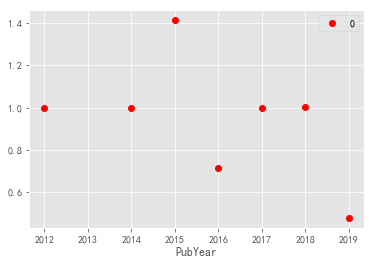

In [11]:
#K-means聚类检测异常值
from sklearn import preprocessing
from sklearn.cluster import KMeans

cluster_data = preprocessing.scale(df_year_group) #标准化数据集
model = KMeans(n_clusters = 3,max_iter = 500)#聚类器，分为3类
model.fit(cluster_data)
cluster_data = pd.DataFrame(cluster_data,index = df_year_group.index)
cluster_data['labels'] = model.labels_

#计算簇内每个点对于簇中心的相对距离（相对距离 = 点到簇中心的距离/这个簇所有点到簇中心距离的中位数）
norm = []
for i in range(3):
    norm_tmp = cluster_data[cluster_data['labels']==i].drop('labels',axis=1)-model.cluster_centers_[i]
    norm_tmp = norm_tmp.apply(np.linalg.norm,axis = 1)#求范数
    norm.append(norm_tmp/norm_tmp.median())

norm=[pd.DataFrame(z) for z in norm]
print(norm)
norm = pd.concat(norm)#合并
#print(norm.head(8))

#可视化
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
norm.plot(style = 'ro')

## K-means聚类检测异常值结果分析
* 通过对2012-2019年Cost和Qty汇总数据聚类分析也可以看出：2013年较其他年份，数据比较特殊
* 当n_clusters = 1时，也就是没有进行分类时，从图中很明显能看出2013年离群距离最远；当n_clusters = 2/3/4时，2013年都被分成单独的一类，其他年份都是相近年份被分成一类，也就进一步说明2013年数据比较异常，其他年份数据比较符合常理
* 以上，通过对2012-2019年Cost和Qty汇总数据简单可视化和聚类分析，初步得出2013年份数据比较特殊，当然，也还可以从各种武器类型的Cost和Qty汇总数据来做同样的分析；接下来将通过其他的技术来分析各种武器类型的Cost和Qty汇总数据，并可视化展现

In [12]:
#按年份、武器汇总Cost和Qty
df_year_forcetype = pd.DataFrame(columns=['CostR','CostHA','CostSA','CostCA','CostCC','CostALL','QtyR','QtyHA','QtySA','QtyCA','QtyCC','QtyALL'])

def group_sum(columns_name):
    for column in columns_name:
        df_year_forcetype[column]=df_fillna.groupby(["PubYear","ForceType"])[column].sum()

columns_name=['CostR','CostHA','CostSA','CostCA','CostCC','CostALL','QtyR','QtyHA','QtySA','QtyCA','QtyCC','QtyALL']
group_sum(columns_name)
df_year_forcetype.head(50)

CostR      CostHA      CostSA  \
PubYear ForceType                                                           
2012    af aircraft                    28165054.0  28295554.0  23438128.0   
        af ammo                         1078130.0   1078130.0   1078130.0   
        af missile                     12148034.0  13396034.0  10488569.0   
        af other                       35204072.0  35154926.0  34575026.0   
        army aircraft                  14122762.0  12531062.0   8694421.0   
        army ammo                       3985250.0   3985250.0   3502856.0   
        army missile                    2957436.0   2913951.0   2361936.0   
        army other                     19365184.0  18749395.0  11469730.0   
        army wtcv                       3867024.0   5149542.0   3980019.0   
        defense wide                   10730496.0  10025896.0   8254144.0   
        joint impr explosive             441268.0    441268.0   -220634.0   
        joint urgent operational fund    200000.0   -100000.0    200000.0   
        marine corps                    2783204.0   2786204.0   2483108.0   
        national guard reserve equip     300000.0         0.0         0.0   
        navy aircraft                  37174066.0  37187566.0  34194259.0   
        navy shipbuilding conv         29857842.0  29707842.0  29857842.0   
        navy weapons                    6816956.0   6831956.0   5820818.0   
2013    af aircraft                    22005998.0  22947098.0  19279754.0   
        af ammo                         1198388.0   1198388.0   1198388.0   
        af missile                     10983692.0  11028692.0  10983692.0   
        af other                       33440896.0  33440896.0  33440896.0   
        army aircraft                  11707458.0  11707458.0  11575458.0   
        army ammo                       3479412.0   3156012.0   2980098.0   
        army missile                    2605378.0   2785378.0   2605378.0   
        army other                     12652490.0    189932.0         0.0   
        army wtcv                       3003412.0   4150894.0     -1770.0   
        defense wide                    8375870.0       227.0         0.0   
        marine tracked combat veh       3245910.0   2823210.0   2420310.0   
        navy ammo                       1519078.0         0.0         0.0   
        navy other                     12338756.0         0.0         0.0   
        navy shipbuilding conv         27159690.0        26.0         0.0   
        navy weapons                    6235156.0      4306.0         0.0   
2014    af aircraft                    22797802.0  23728402.0  22746202.0   
        af ammo                         1518884.0   1518884.0   1518884.0   
        af missile                     10686572.0  10684463.0  10686572.0   
        af other                       33521162.0  33521162.0  33521162.0   
        army ammo                       3080874.0   2857374.0   2826474.0   
        army missile                    2668166.0   2668166.0   2668166.0   
        army other                     12930436.0  12767536.0  12930436.0   
        army wtcv                       3194534.0   3767534.0   2716217.0   
        defense wide                    9068166.0   9389166.0   9103698.0   
        marine corps                    2687022.0   2687022.0   2687022.0   
        navy aircraft                  35855302.0  35945302.0  35951302.0   
        navy mc ammo                    1178534.0   1178534.0   1178534.0   
        navy other                     12620514.0  12541932.0  12620514.0   
        navy shipbuilding conv         28155608.0  30958508.0  28621508.0   
        navy weapons                    6244386.0   6202086.0   6263586.0   
2015    af aircraft                    23085142.0  22717129.0  23037442.0   
        af ammo                         1354800.0   1354800.0   1381200.0   
        af missile                      9381012.0   9777012.0   8962419.0   

                                       

[ 0  5 10 15 20 25 30 35]
[99321053.0, 87621848.0, 91695608.0, 92569355.0, 129885704.0, 112159736.0, 162440541.0, 130325633.0]


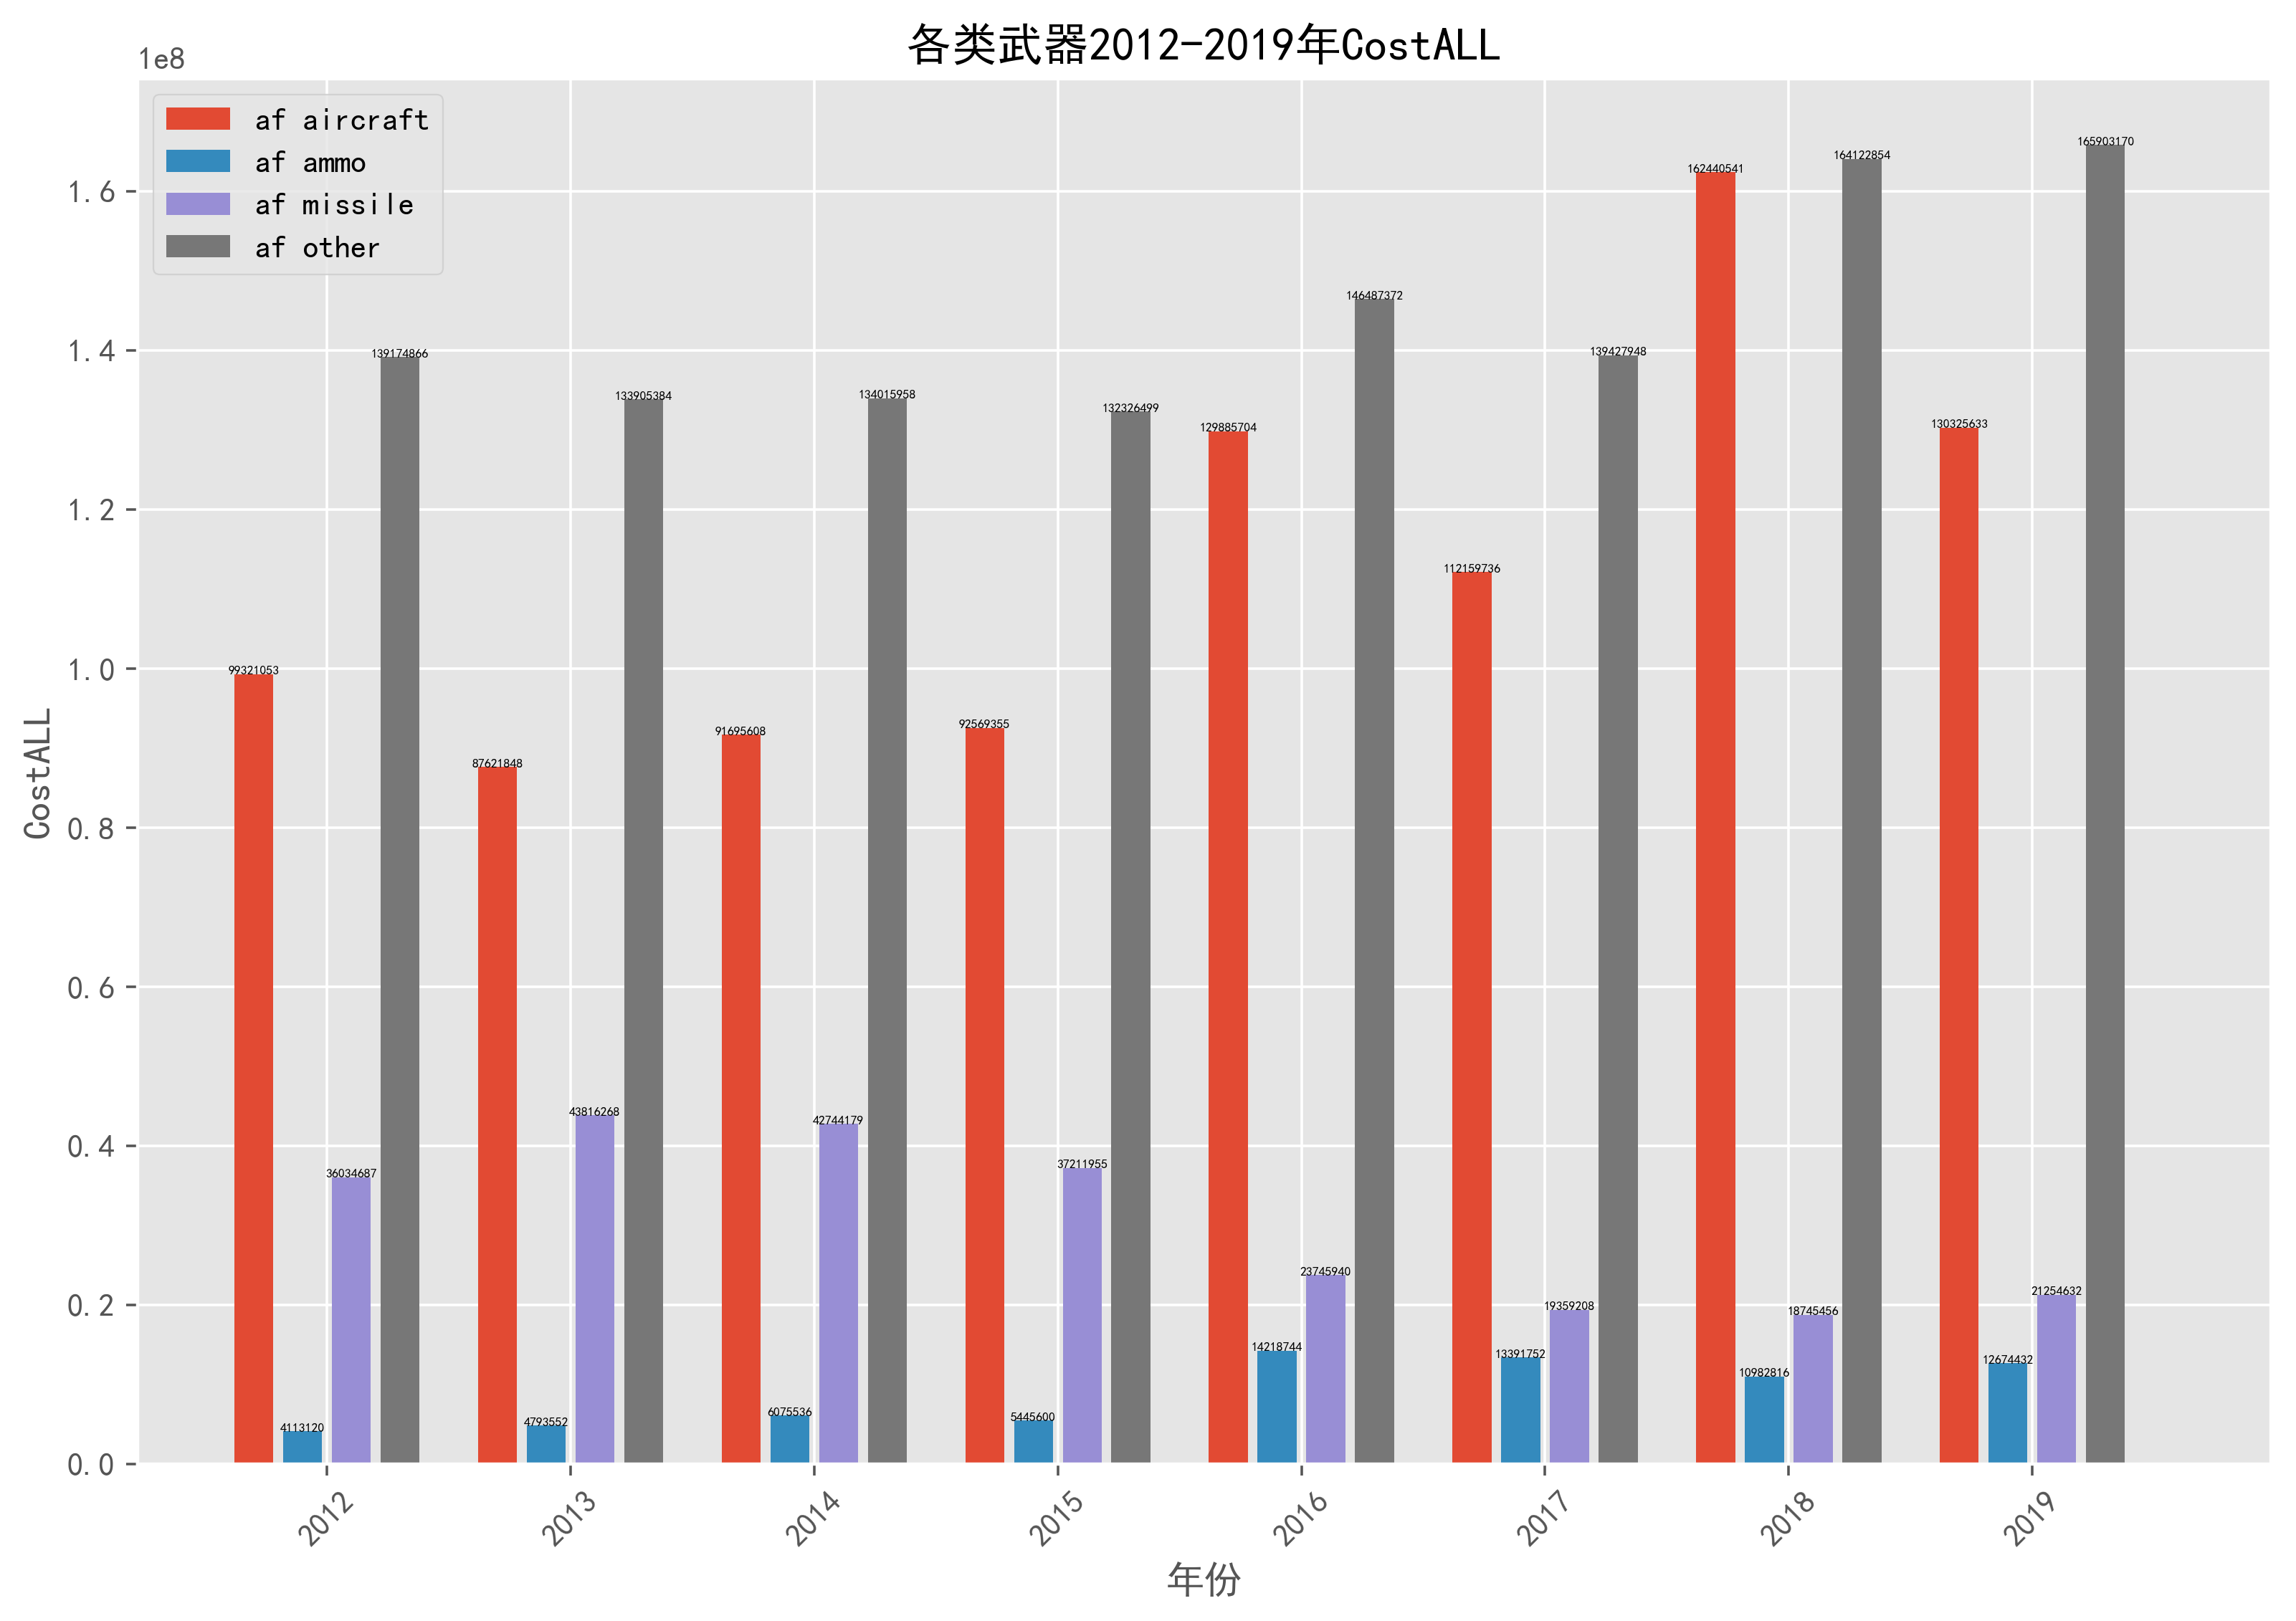

In [13]:
#各类武器2012-2019年关于CostALL直方图(先展示四类武器)

#取各类武器2012-2019年的costall列表
def forcetype_list(weapon,df=df_year_forcetype):
    weapon_costall_list=[]
    for i in range(2012,2020):
        weapon_costall_list.append(df_year_forcetype.loc[(i,weapon),'CostALL'])
    return weapon_costall_list
af_aircraft_costall=forcetype_list("af aircraft")
af_ammo_costall=forcetype_list("af ammo")  
af_missile_costall=forcetype_list("af missile")  
af_other_costall=forcetype_list("af other")  

#绘制直方图
p1=plt.figure(figsize=(12,8),dpi=320)#画布大小，分辨率；
plt.rcParams['font.sans-serif'] = 'SimHei'#仿宋
plt.title('各类武器2012-2019年CostALL')
x = [j for j in range(2012,2020)]
x1=np.array([i for i in range(0,40,5)])
#将每四个柱状图之间空一格
x2=x1+1
x3=x1+2
x4=x1+3
x5=x1+4
y2 = af_aircraft_costall
y3 = af_ammo_costall
y4 = af_missile_costall
y5 = af_other_costall
print(x1)
print(y2)
plt.bar(x1,y2)
plt.bar(x2,y3) 
plt.bar(x3,y4)
plt.bar(x4,y5)
plt.bar(x5,[0,0,0,0,0,0,0,0])
plt.xlabel('年份')
plt.ylabel('CostALL')
plt.legend(['af aircraft','af ammo','af missile','af other'])
#在每一个柱上添加相应值
for a,b,c,d,e,f,g,h in zip(x1,x2,x3,x4,y2,y3,y4,y5):
    plt.text(a,e+100,int(e),fontsize=4,ha='center')
    plt.text(b,f+100,int(f),fontsize=4,ha='center')
    plt.text(c,g+100,int(g),fontsize=4,ha='center')
    plt.text(d,h+100,int(h),fontsize=4,ha='center')
plt.xticks(x1+1.5,x,rotation = 45)#+1.5是让下标在四个柱子中间
plt.show()

['af aircraft', 'af ammo', 'af missile', 'af other', 'army aircraft', 'army ammo', 'army missile', 'army other', 'army wtcv', 'defense wide', 'marine corps', 'navy aircraft', 'navy mc ammo', 'navy other', 'navy shipbuilding conv', 'navy weapons', 'af space', 'navy ammo', 'joint impr defeat fund', 'joint urgent oper need fund', 'prior yr rescissions', 'marine tracked combat veh', 'undistributed provisions', 'joint impr explosive', 'joint urgent operational fund', 'national guard reserve equip']


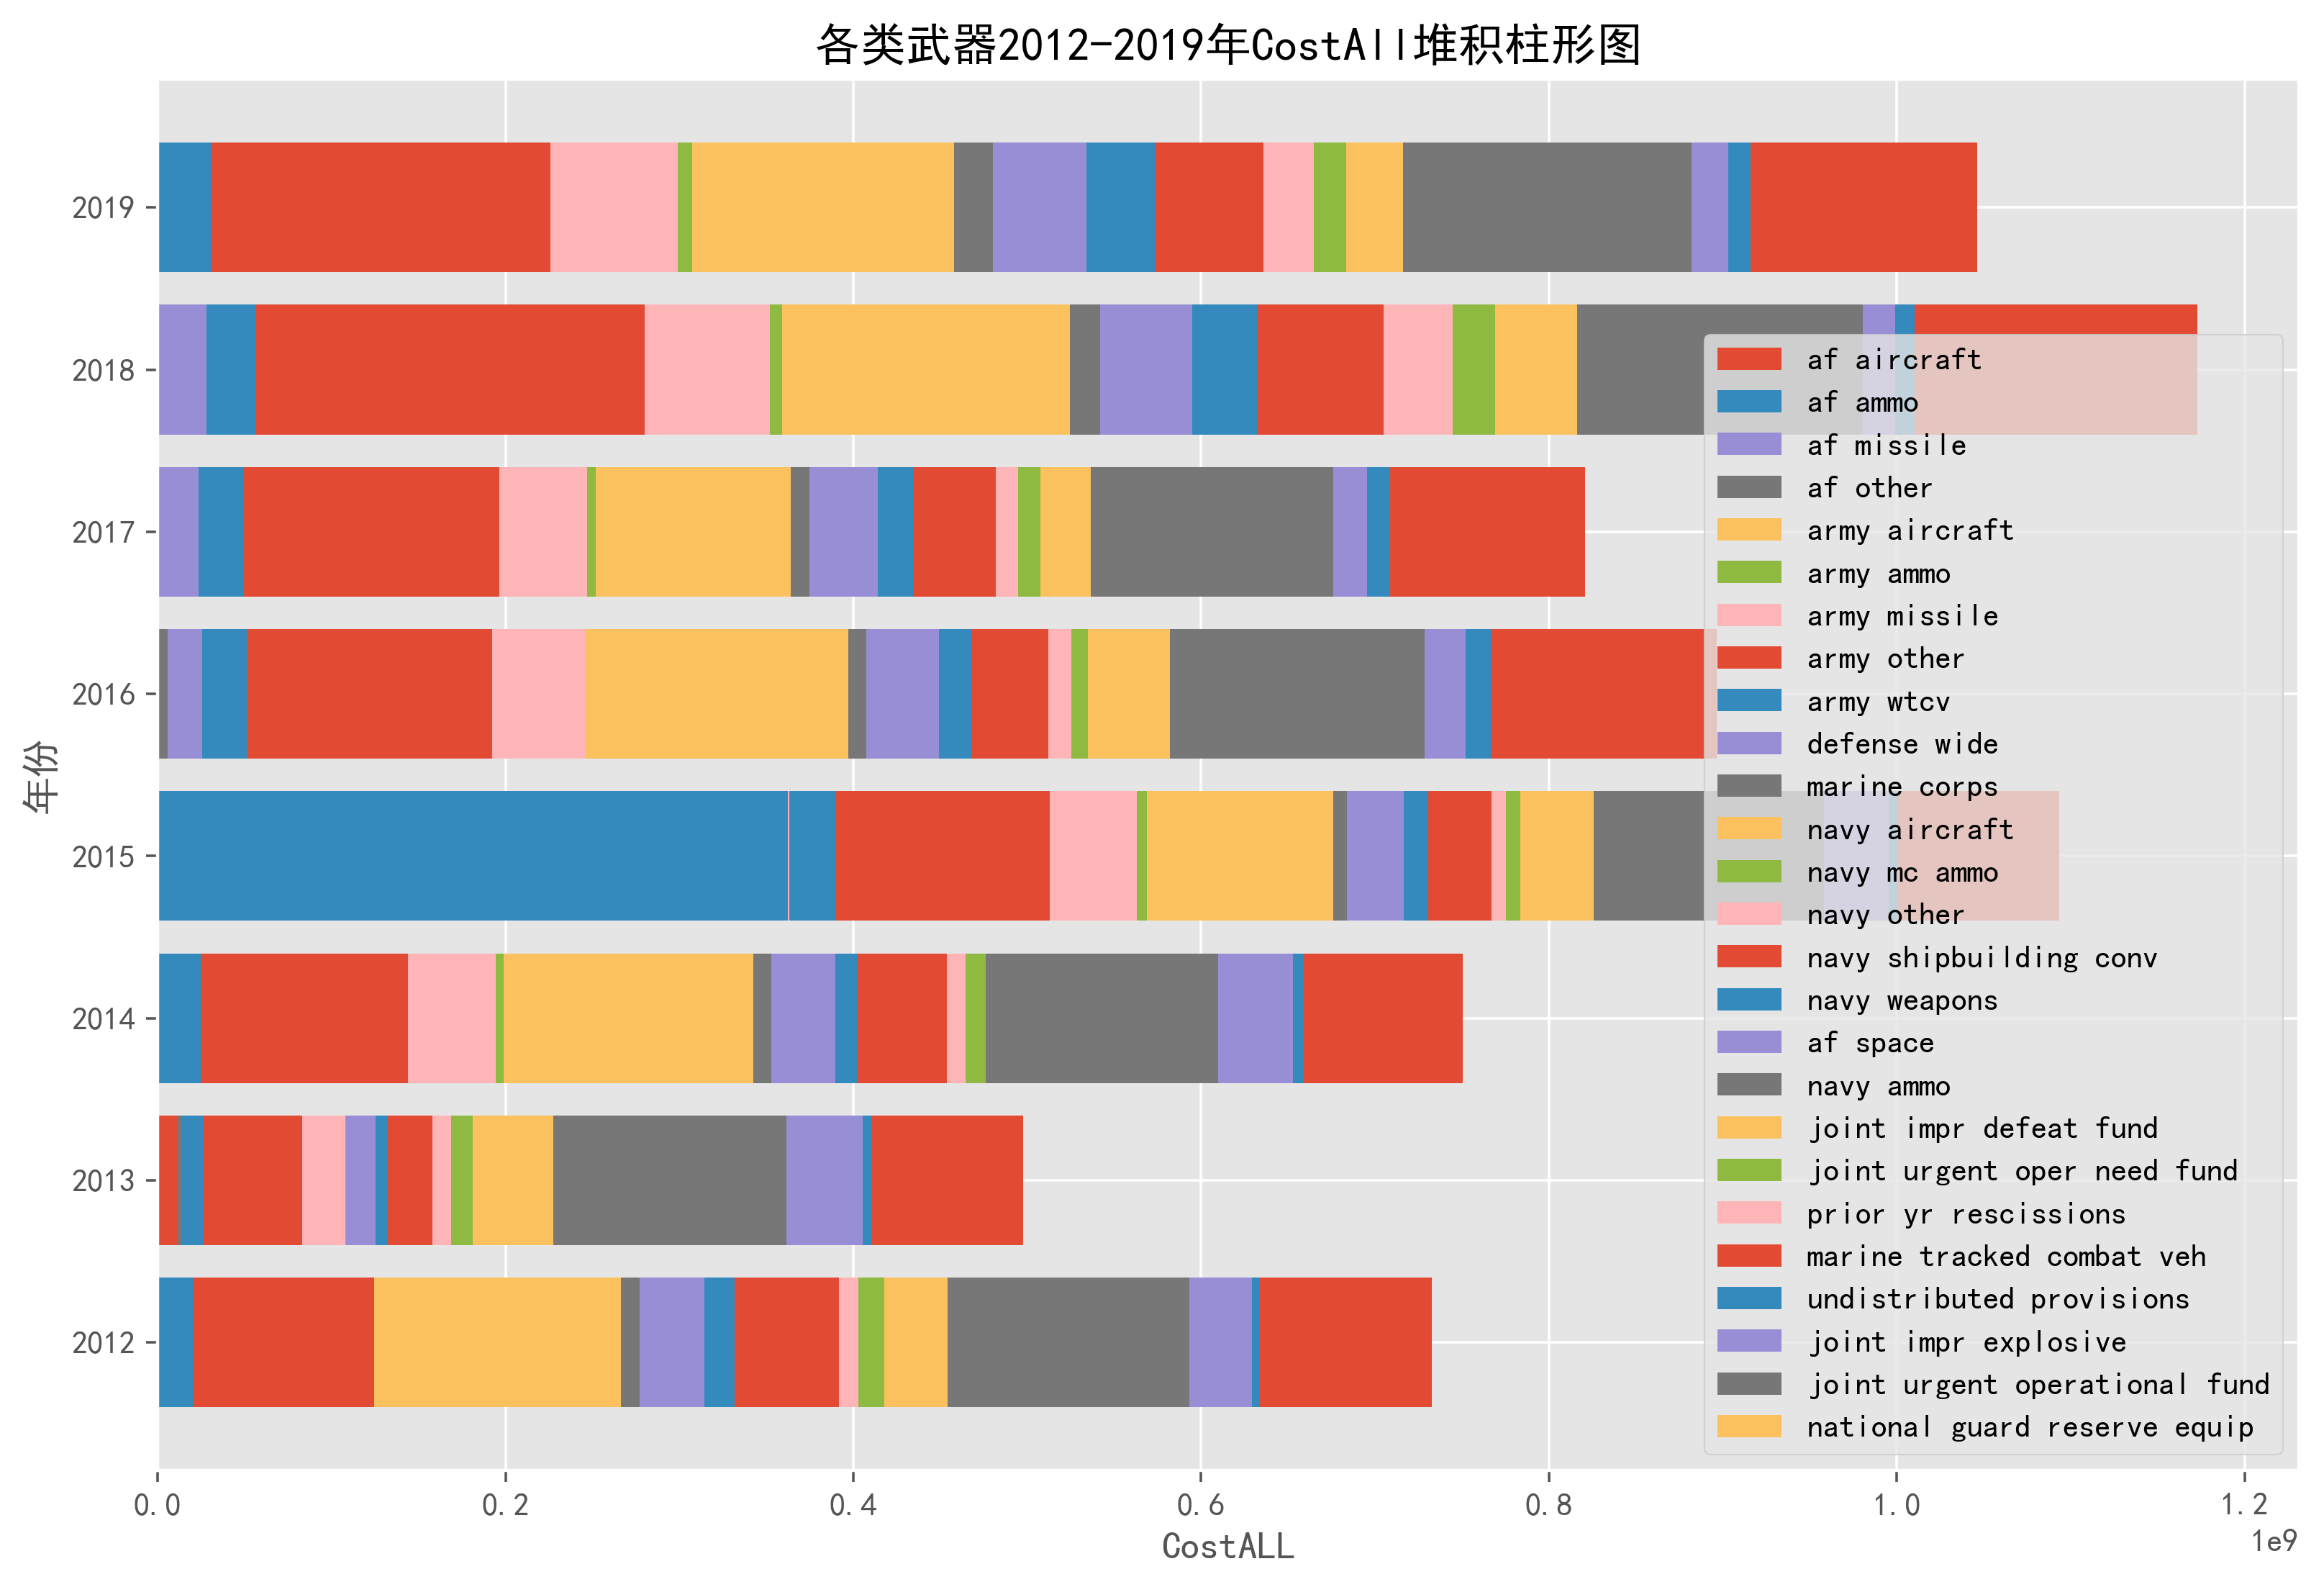

In [14]:
#各类武器2012-2019年CostAll堆积柱形图（参考M国国防预算分析报告）

#取各类武器2012-2019年CostAll数据:forcetype_matrix
all_forcetype=df_fillna["ForceType"].unique()
all_forcetype=all_forcetype.tolist()#所有武器类型list，26个
print(all_forcetype)

def pd_serise_tolist(serise,index):#按某一index顺序转换成list
    serise_list=[]
    for i in index:
        serise_list.append(serise[i])
    return serise_list
    
forcetype_matrix=[]
for i in range(2012,2020):   
    temp=df_year_forcetype.loc[(i,),'CostALL']
    index_temp=temp.index
    for index in all_forcetype:
        if index not in index_temp:
            temp[index]=0
    temp=pd_serise_tolist(temp,all_forcetype)
    forcetype_matrix.append(temp)#需要按统一顺序转换成list
#print(forcetype_matrix)

p1=plt.figure(figsize=(12,8),dpi=320)#画布大小，分辨率；
plt.rcParams['font.sans-serif'] = 'SimHei'#仿宋
plt.title('各类武器2012-2019年CostAll堆积柱形图')#26类
year = [j for j in range(2012,2020)]

#定义函数求V2-V26
def get_v(v_pre,i):
    v=[]
    temp=[z[i-2] for z in forcetype_matrix]
    v=[ z[0]-z[1] for z in  zip(v_pre, temp)]
    return v

v1=[sum(z) for z in forcetype_matrix]
v2=get_v(v1,2)
v3=get_v(v2,3)
v4=get_v(v3,4)
v5=get_v(v4,5)
v6=get_v(v5,6)
v7=get_v(v6,7)
v8=get_v(v7,8)
v9=get_v(v8,9)
v10=get_v(v9,10)
v11=get_v(v10,11)
v12=get_v(v11,12)
v13=get_v(v12,13)
v14=get_v(v13,14)
v15=get_v(v14,15)
v16=get_v(v15,16)
v17=get_v(v16,17)
v18=get_v(v17,18)
v19=get_v(v18,19)
v20=get_v(v19,20)
v21=get_v(v20,21)
v22=get_v(v21,22)
v23=get_v(v22,23)
v24=get_v(v23,24)
v25=get_v(v24,25)
v26=get_v(v25,26)

plt.barh(year,v1)
plt.barh(year,v2)
plt.barh(year,v3)
plt.barh(year,v4)
plt.barh(year,v5)
plt.barh(year,v6)
plt.barh(year,v7)
plt.barh(year,v8)
plt.barh(year,v9)
plt.barh(year,v10)
plt.barh(year,v11)
plt.barh(year,v12)
plt.barh(year,v13)
plt.barh(year,v14)
plt.barh(year,v15)
plt.barh(year,v16)
plt.barh(year,v17)
plt.barh(year,v18)
plt.barh(year,v19)
plt.barh(year,v20)
plt.barh(year,v21)
plt.barh(year,v22)
plt.barh(year,v23)
plt.barh(year,v24)
plt.barh(year,v25)
plt.barh(year,v26)

plt.xlabel('CostALL')
plt.ylabel('年份')
forcetype_legend=all_forcetype
plt.legend(forcetype_legend)  #设置图例
plt.show()

## 按照武器类型分析：
* 直方图分析：略
* 堆积柱形图分析：从图中可以看出，af aircraft、navy aircraft、navy shipbuilding conv类型武器经费开支占比相对比较多。2015年undistributed provisions（未分配资金）的占比非常大，相比其他年份有些异常。

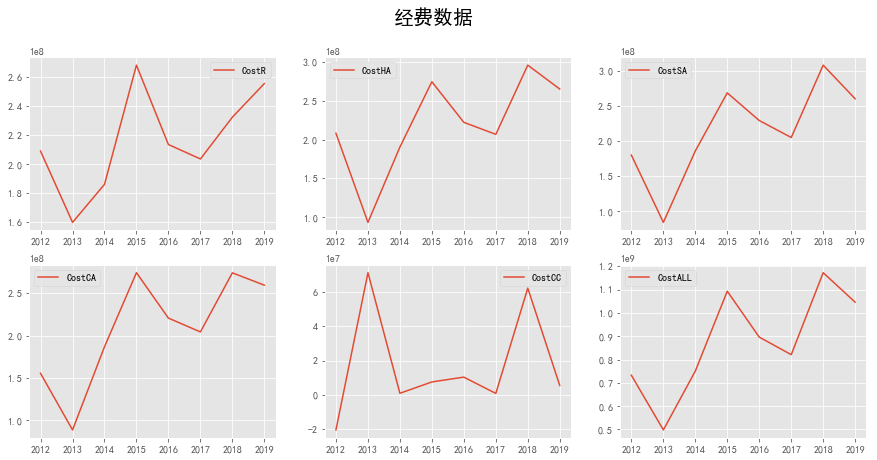

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will r

参数错误: (0, 2)


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Program Files (x86)\Microso

参数错误: (2, 1)


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


最优模型:                                ARMA Model Results                              
Dep. Variable:                CostALL   No. Observations:                    8
Model:                     ARMA(0, 1)   Log Likelihood                -162.936
Method:                       css-mle   S.D. of innovations      147704445.858
Date:                Thu, 21 May 2020   AIC                            331.872
Time:                        15:34:04   BIC                            332.110
Sample:                    01-01-2012   HQIC                           330.264
                         - 01-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.763e+08   9.91e+07      8.843      0.000    6.82e+08    1.07e+09
ma.L1.CostALL     1.0000      0.466      2.145      0.076       0.086       1.914
                                 

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


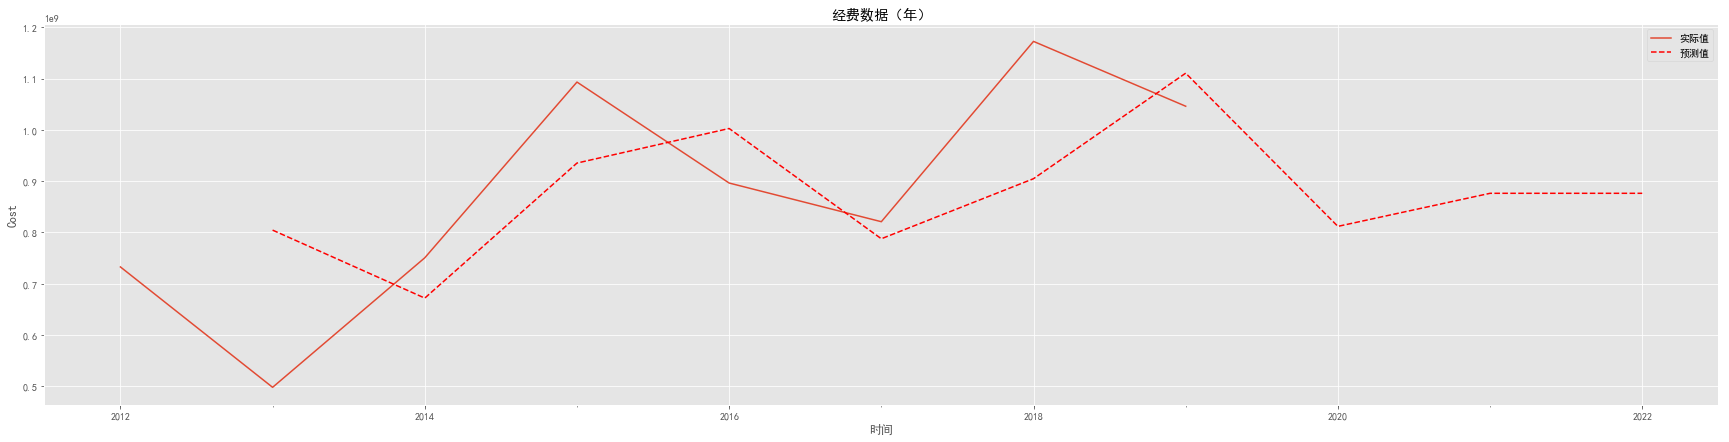

In [15]:
# 时序分析，预测未来几年CostALL（CostR、CostHA、CostSA、CostCA、CostCC）
df_year_group.index = pd.to_datetime(df_year_group.index,format='%Y',errors='coerce')# 将索引转换成时间索引

from statsmodels.tsa.arima_model import ARMA
from itertools import product
from datetime import datetime
# 绘制时序图，观察数据特征
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('经费数据', fontsize=20)
plt.subplot(231)
plt.plot(df_year_group["CostR"], '-', label='CostR')
plt.legend()
plt.subplot(232)
plt.plot(df_year_group["CostHA"], '-', label='CostHA')
plt.legend()
plt.subplot(233)
plt.plot(df_year_group["CostSA"], '-', label='CostSA')
plt.legend()
plt.subplot(234)
plt.plot(df_year_group["CostCA"], '-', label='CostCA')
plt.legend()
plt.subplot(235)
plt.plot(df_year_group["CostCC"], '-', label='CostCC')
plt.legend()
plt.subplot(236)
plt.plot(df_year_group["CostALL"], '-', label='CostALL')
plt.legend()
plt.show()

# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs) #网格
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_year_group["CostALL"],order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置需要预测的时间date_list
df_year_group2 = df_year_group[["CostALL"]]
date_list = [datetime.strptime('2020', '%Y'),datetime.strptime('2021', '%Y'),datetime.strptime('2022', '%Y')]

# 添加未来要预测的3年
future = pd.DataFrame(index=date_list, columns= df_year_group.columns)
df_year_group2 = pd.concat([df_year_group2, future])
df_year_group2['forecast'] = best_model.predict(start=0, end=len(df_year_group2))
# 第一个元素不正确，设置为NaN
df_year_group2['forecast'][0] = np.NaN
print(df_year_group2)

# 预测结果显示
plt.figure(figsize=(30,7))
df_year_group2["CostALL"].plot(label='实际值')
df_year_group2.forecast.plot(color='r', ls='--', label='预测值')
plt.legend()
plt.title('经费数据（年）')
plt.xlabel('时间')
plt.ylabel('Cost')
plt.show()

## CostAll时间序列分析预测：
* 通过ARMA(0,1)模型预测了2020-2022年的CostAll,结果见上图
* 时序模型预测结果具有一定延时性

(-0.5, 399.5, 199.5, -0.5)

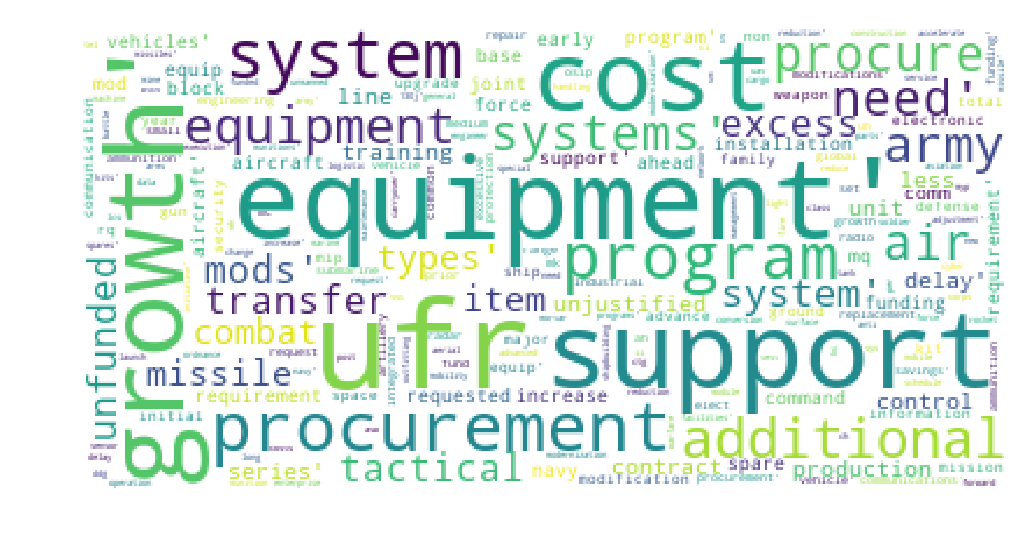

In [17]:
# 词云：将所有的item用词云展示
from wordcloud import WordCloud
from collections import Counter

# 数据处理：大小写，前后空格换行符删除
df_fillna['Item']=df_fillna['Item'].apply(lambda x: x.strip())
df_fillna['Item']=df_fillna['Item'].apply(lambda x:x.lower())
words=df_fillna['Item'].tolist()
count = Counter(words)
most_count = count.most_common() #list[(key,val),]
# 词云绘制
wordcloud = WordCloud(background_color = 'white',collocations=False, #避免重复单词 
                          max_words = 1000)
wordcloud.generate(str(most_count))

plt.figure(dpi=200) #通过这里可以放大或缩小
plt.imshow(wordcloud)
plt.axis("off") #隐藏坐标

# print(most_count)
# print(type(most_count))

## Item词云展示
* 词云图直观的展示了2012-2019年美军采购的主要item
* 由于每一个item是一个句子，词云展示不能全部显示每个item，后续将对这一问题进行优化

In [ ]:
# 关联规则，将每年的item当做一个transaction，探索item间的关联关系
from efficient_apriori import apriori
import pyfpgrowth

# # 得到一维数组Item_series，并且将PubYear作为index, value为Item取值
Item_series = df_fillna.set_index('PubYear')['Item']

# 将数据集进行格式转换
transactions = []
temp_index = 0
for i, v in Item_series.items():
    if i != temp_index:
        temp_set = set()
        temp_index = i
        temp_set.add(v)
        transactions.append(temp_set) # 注意：当temp_set添加元素时，transactions中也会同步添加
    else:
        temp_set.add(v)
# print(transactions)

# 挖掘频繁项集和频繁规则
# itemsets, rules = apriori(transactions, min_support=0.02,  min_confidence=0.5)
# apriori算法内存超限，选择使用FP_Growth算法
patterns = pyfpgrowth.find_frequent_patterns(transactions, 2)
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
# print('频繁项集：', itemsets)
print('关联规则：', rules)

## Item关联分析
* 将每年的item当做一个transaction，探索item间的关联关系

### 问题及下一步工作
* 问题1：经费数字画像最终的目的是基于数字画像结果，感知M方的战略意图，那么怎么设计体现战略意图的指标❓另外，经费数据中只有武器类型、经费、数量、主题，只能通过无监督的学习方式感知M方的战略意图吗❓还是需要人工标注？
* 问题2：还可以怎么画像：标签怎么设计？怎么通过特征组合打标签？其他方法？
* 下一步工作：处理其他文本数据集，尝试知识图谱库的搭建等，参考上次会议王涛老师发言。


## 文献阅读
### M国空军战略总计划
* 空军战略的**五个战略方向**（确定了投资、制度变更和作战理念方面需要优先发展的领域）   
1.提供有效的21世纪威慑力：核使命仍是空军领导人需要优先考虑的问题，但是空军同样具备很多其它能力，以威慑各类势力。  
2.维持强健灵活的全球情报、监视和侦察（ISR）能力：空军将采用敏捷的多领域解决方案来侦查、描述、威慑和击败对手。这要求制定一种能够为指挥官提供多种选项的敏捷、协调的多领域ISR方法。  
3.确保全方位胜任、高端专注的空军：空军必须注重技巧和能力，以便在高强度对抗的空域内具备机动自由并能采取决定性行动。但是，我们必须保有低强度冲突中获胜的能力。  
4.寻求多领域方法完成五大核心任务：为实现军事作战范围内最有效的解决方案，除了空中能力，我们还将逐步整合和利用网络空间和空域内的作战能力。  
5.继续追求改变游戏规则的技术：我们必须持续寻求在技术方面的重大改进，结合新方法以及组织机构变革，扩大或维持我们对对手的绝对优势。这要求在思维方式上确立出并实现重大突破，以扩大和巩固我军在领空和网络空间的优势。
* 战略总计划范围和结构（涉及人员、地点、事件和未来；这些附件将SMP的总体目标转化成**具体的行动和优先事项**）  
1.人力资本附件（HCA）  
2.战略态势附件（SPA）  
3.能力附件（CA）  
4.科技附件（STA）  

### 基于互联网文本挖掘的用户意图感知
* **意图**表达的是对一个对象的期望集合
* 用户意图可用**因素集**来表达
* **互联网文本挖掘求解因素集->验证因素集真实度(确保因素集真实反映用户意图)**
* 利用**互联网文本挖掘技术**获取用户意图的因素集：具体见技术路线图
* 采用**正反问卷**对每个因素进行测量：正反面问卷指同一个指标设计成正反两个问题，可以用来检测问卷资料的真实度
* ITMT方法获取的因素集数据比较丰满，但也比较分散，传统用户意图研究方法容易忽略一些重要因素
* ITMT获取因素集对数据量有一定要求，数据量影响着效果（1 000 pages）

### 用户意图感知及其功能转换设计
* 用户意图存在模糊性的特点,采用模糊集对用户意图进行表达
* 定义因素集，构造综合评价矩阵,通过引入熵来反映指标在整个指标体系中的对评价对象的区分度（特征权重）:当各备选项目在某一指标上的值完全相同时，该指标的熵达到最大值 1 ，其熵权为零,这说明该指标未能向决策者供有用的信息，可考虑去掉该指标

### Analysis of the 2020 Defense Budget Request 
* 堆积柱形图

### 战略意图感知思路
* 参考《战略总计划》，假设战略意图的研究对象包括人力资本、战略态势、能力、科技四个部分（待定，怎么分比较合理？）
* M军对以上四个研究对象的意图可用因素集来表达
* 因素集可通过挖掘相关数据得到（除了经费数据，还需要哪些数据才能涵盖M军的战略意图呢？）
* 最后验证因素集的真实度（这里应该采用什么方法呢？专家验证？）

In [ ]:
# #将数据导出到csv文件中
# df.to_csv("./authorized_procurement_cluster_result.csv")